# Data Source
* [Food Production](https://www.fao.org/faostat/en/#data/QCL)

This is the complete dataset of food production from the FAO. 

# Data Preparation

In [1]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the data in
food_prod = pd.read_csv("data" + os.sep + "food production" + os.sep + "Production_Crops_Livestock_E_All_Data_NOFLAG.csv", sep=",", encoding="latin-1")
#food_prod.head()

In [3]:
# only use production amounts and not the other kinds of data
food_prod = food_prod[food_prod["Element"] == "Production"]
#food_prod.head()

In [4]:
# only use the production data from the years iself without the meta data
food_prod = food_prod.iloc[:,7:]
#food_prod.head()

In [5]:
# Calculate total sums for the years
food_prod = food_prod.sum(axis=0)
food_prod = pd.DataFrame(pd.Series(food_prod))
food_prod.columns = ["Production"]
#food_prod.tail()

This provides us with a global food production in tons for all years from 1961 to 2020.

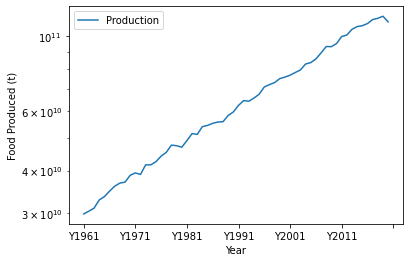

In [6]:
# Plot it
ax= food_prod.plot()
ax.set_ylabel("Food Produced (t)")
ax.set_xlabel("Year")
ax.set_yscale("log")
# Is the drop in 2020 real? Seems pretty big

# Calculate the food shocks
To get the food shocks we have to analyze by how much the food changed year by year in percent. 

In [7]:
# Calculate the percentage change in food production each year
food_prod["prc_change"] = food_prod["Production"].pct_change()*100
#food_prod.head()

Once we got those we can calculate the average growth in global food production per year. 

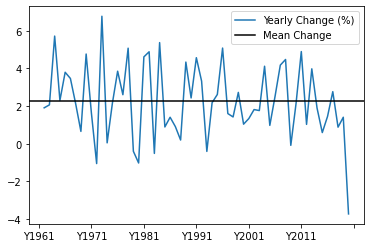

In [8]:
# Plot the percentage food production changes
ax = food_prod["prc_change"].plot(label="Yearly Change (%)")
ax.axhline(food_prod["prc_change"].mean(), label="Mean Change",color="black")
ax.legend()

Based on the mean growth rate, we can calculate by how much each year derivated from this. All the negative values are our food production shocks. 

In [9]:
# Calculate diff to mean change
food_prod["Difference"] = food_prod["prc_change"] - food_prod["prc_change"].mean()

Text(0, 0.5, 'Difference in global production to mean')

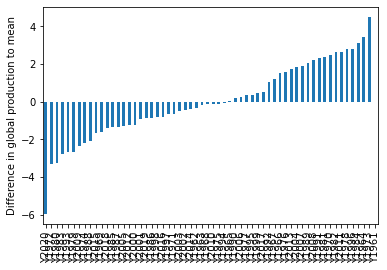

In [10]:
# plot the sorted difference
ax = food_prod["Difference"].sort_values().plot(kind="bar")
ax.set_ylabel("Difference in global production to mean")

Set all values above 0 to 0, as we are only interested in the shocks


In [11]:
food_prod["Difference"] = food_prod["Difference"].where(food_prod["Difference"]<0, other=0)

# Cumulative distribution fitting 

In [12]:
# set all negative values to absolute values to make the fitting more straightforward
food_prod["Difference"] = abs(food_prod["Difference"])

In [13]:
# Sort for further calculations with cumsum
food_prod=food_prod.sort_values("Difference",ascending=False)

In [14]:
# calculate the time fraction
years = food_prod.shape[0]
food_prod["time"] = 1/years
food_prod["Frequency"] = np.cumsum(food_prod["time"])
food_prod.head()

,Production,prc_change,Difference,time,Frequency
Y2020,1.103574e+11,-3.728487,5.992450,0.016667,0.016667
Y1972,3.896966e+10,-1.053685,3.317647,0.016667,0.033333
Y1980,4.693613e+10,-1.022995,3.286958,0.016667,0.050000
Y1983,5.123558e+10,-0.514436,2.778399,0.016667,0.066667
Y1993,6.423281e+10,-0.408120,2.672082,0.016667,0.083333


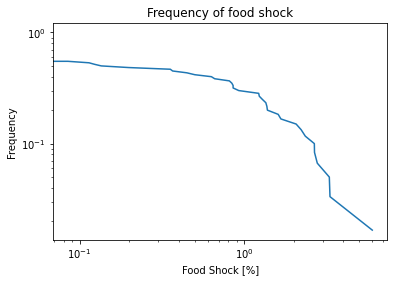

In [15]:
# Plot
fig = plt.Figure()
plt.plot(food_prod["Difference"], food_prod["Frequency"])
ax = plt.gca()
ax.set_xlabel("Food Shock [%]")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of food shock")
ax.set_xscale("log")
ax.set_yscale("log")

As this isn't a straight line in loglog space, this does not seem to be a power law. 

## Fitting with power law

In [16]:
# Fit data to power law
def func_powerlaw(x, m, c):
    return x**m * c
params, covar = curve_fit(func_powerlaw, food_prod["Difference"], food_prod["Frequency"], maxfev=1000000)
params

array([2.67875769e-08, 2.74324714e-01])

Same goes for fitting with a power law, which does not really work great. 

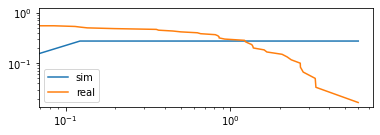

In [17]:
# Plot the power law
x_sim = np.linspace(0,6)
y_sim = func_powerlaw(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(food_prod["Difference"], food_prod["Frequency"], label="real")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## Fitting with lognormal

/home/florian/local/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/florian/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


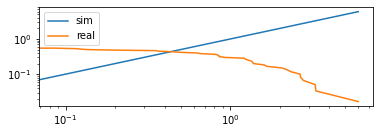

In [18]:
# Fit data to lognormal
def lognormal(x,upsilon,epsilon):
    numerator=np.exp(-np.power((np.log(x)-upsilon),2)/(2*epsilon**2))
    denominator=x*np.sqrt(2*np.pi*epsilon**2)
    return numerator/denominator
params, covar = curve_fit(lognormal, food_prod["Difference"], food_prod["Frequency"], maxfev=1000000)
# Plot the power law
x_sim = np.linspace(0,6)
y_sim = func_powerlaw(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(food_prod["Difference"], food_prod["Frequency"], label="real")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

And exponential decay


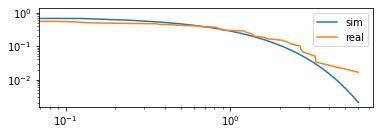

In [19]:
def monoExp(x, m, t):
    return m * np.exp(-t * x) 
params, covar = curve_fit(monoExp, food_prod["Difference"], food_prod["Frequency"], maxfev=1000000)
# Plot the power law
x_sim = np.linspace(0,6)
y_sim = monoExp(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(food_prod["Difference"], food_prod["Frequency"], label="real")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

Seems like exponential decay is the winner when it comes to fitting here.